***
***
# Core Spark Fundamentals

In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("testapp")
sc = SparkContext(conf=conf)
spark = SparkSession.builder \
    .master("local") \
    .appName("testapp") \
    .getOrCreate()

***
***

## What comes with Apache Spark

* Spark is a distributed computing framework
* Core Spark contains all the basic functionality of Spark
  * Contains RDD class and all action/transformation methods which operate on RDDs
* Other modules in Spark sit on top of Core Spark
  * __Spark SQL__ introduces a DataFrame class which acts as a schema-based RDD allowing for SQL syntax for working with data
  * __Spark Streaming__ adds a streaming context object which can be used to do Spark operations on batches of streaming data
  * __MLib__ adds a collection of common machine learning algorithms which may be used with RDDs
  * __GraphX__ indtroduces node and edge classes and a set of common algorithms for analyzing graphs of data

<img src="figs/spark-stack.png">
#### (spark.apache.org)


***

## Let's play with some data!
To start with, let's use some features of Core Spark

***

### Import Moby Dick
This will be our first data set to use with Spark


In [2]:
mobyDick_RDD = sc.textFile("./data/MobyDick.txt")
print("Number of lines in Moby Dick = %d" % mobyDick_RDD.count())
mobyDick_RDD.take(3)

Number of lines in Moby Dick = 22933


['MOBY DICK; OR THE WHALE ', '', 'by Herman Melville']

### Flat map
We have imported Moby Dick as a text file which creates an RDD of strings, each element being a single line in the text file. Let's create a new RDD which has each element being a word in the text.

<img src="figs/flatMap_map.png">

In [3]:
words_RDD = mobyDick_RDD.flatMap(lambda x: x.split(" "))
print("Number of words in Moby Dick = %d" % words_RDD.count())
words_RDD.take(7)

Number of words in Moby Dick = 221044


['MOBY', 'DICK;', 'OR', 'THE', 'WHALE', '', '']

***
### Map
Let's make sure that the data is _clean_ by removing all non-alphabetic characters and making all the words lowercase. To do this, let's create a transformation function maping a string to a lowercase string containing only a-z. We will then apply a map to the words_RDD using the transformation function.

In [4]:
import re
regex = re.compile('[^a-zA-Z]')
def word_transform(word):
    clean_word = regex.sub('', word).lower()
    return clean_word

s1 = "te4st8 w0ord!."
print(s1 + " -> " + word_transform(s1))

te4st8 w0ord!. -> testword


In [5]:
clean_words_RDD = words_RDD.map(lambda x: word_transform(x))
print("Number of words in Moby Dick = %d" % words_RDD.count())
clean_words_RDD.take(7)

Number of words in Moby Dick = 221044


['moby', 'dick', 'or', 'the', 'whale', '', '']

***
### Filter
It looks like we have made some progress on cleaning the data set, but we still have some '' chars left over from blank lines. Let's filter those out of our data set. Additionally, we have lots of common words that are pretty uninteresting (it, the, a, ...). These are stop words and we can also filter those out of our data set. Let's do that using an anonymous funciton. Filter functions need to return True if word should be in new dataset, or False if they should be filtered.

<img src="figs/filter.png">

In [6]:
def word_reader(filename):
    lines = [line.strip() for line in open(filename)]
    lines = [x.lower() for x in lines]
    return (lines)

stop_words = word_reader("./data/stopwords.txt")
stop_words.append('')
print(stop_words[0:7])

['said', 'all', 'just', 'being', 'over', 'both', 'through']


In [7]:
clean_filtered_words_RDD = clean_words_RDD.filter(lambda word: word not in stop_words)
print("Number of words in Moby Dick = %d" % clean_filtered_words_RDD.count())
clean_filtered_words_RDD.take(7)

Number of words in Moby Dick = 108296


['moby', 'dick', 'whale', 'herman', 'melville', 'etymology', 'supplied']

In [8]:
print("We just filtered %d stop words from the text!" % (clean_words_RDD.count() - clean_filtered_words_RDD.count()))

We just filtered 112748 stop words from the text!


***
### Map reduces

We now have a RDD which contains a nice list of clean words from Moby Dick. Let's see how common certain words are by mapping words to a key value pair (word, 1) and then reducing on word key and summing the values.

In [9]:
word_count_RDD = clean_filtered_words_RDD.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y)
print("Number of unique clean words in Moby Dick = %d" % word_count_RDD.count())
word_count_RDD.take(7)

Number of unique clean words in Moby Dick = 19636


[('moby', 80),
 ('melville', 2),
 ('late', 30),
 ('consumptive', 1),
 ('usher', 1),
 ('grammar', 2),
 ('school', 9)]

***
### SortBy
There is an arbitrary sort method for RDDs which allows you to work with non-trivial data -> sorting CIS student assessment RDDs by outcome comes to mind... :)

In [10]:
sorted_word_count_RDD = word_count_RDD.sortBy(lambda x: x[1], ascending=False)
sorted_word_count_RDD.take(7)

[('whale', 955),
 ('one', 889),
 ('like', 575),
 ('upon', 565),
 ('old', 440),
 ('man', 435),
 ('would', 427)]

***
### Plotting word frequency
Awesome! We now know how frequenctly unque words occur in Moby Dick. Let's visualize this now using a word cloud. We should first collect the RDD from Spark back to the driver (this is essentially creating a local data structure from an RDD). We could return the sorted words as a list of tuples using _collect()_, or we could return as a python dict using _collectAsMap()_. We will use list method for now.

In [11]:
sorted_word_count_list = sorted_word_count_RDD.collect()
sorted_word_count = {x[0]: x[1] for x in sorted_word_count_list}
sorted_word_count_list[0:7]

[('whale', 955),
 ('one', 889),
 ('like', 575),
 ('upon', 565),
 ('old', 440),
 ('man', 435),
 ('would', 427)]

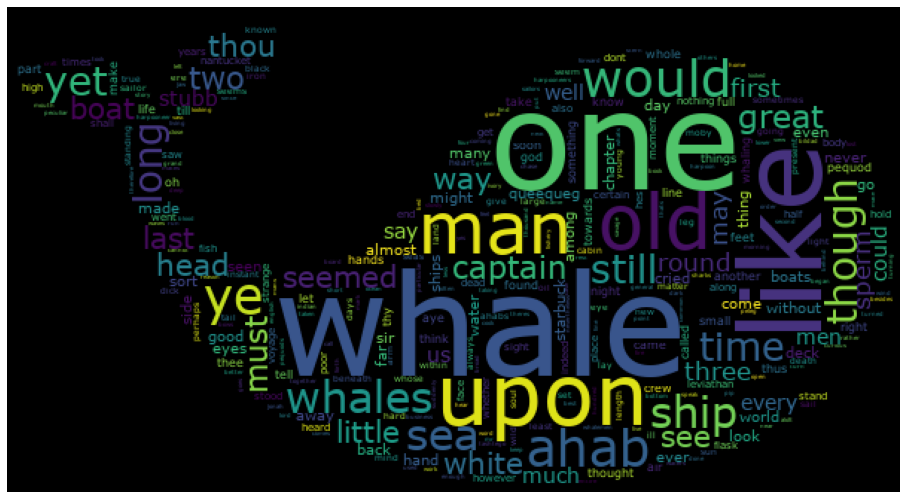

In [12]:
%matplotlib inline
# from os import path, system
import subprocess
from imageio import imread
import matplotlib.pyplot as plt

try:
    from wordcloud import WordCloud
except:
    rc = subprocess.call("/data/install_word_cloud.sh")
    from wordcloud import WordCloud

whale_mask = imread("./figs/whale.png")
wc = WordCloud(background_color="black", max_words=2000,
               font_path='./figs/Verdana.ttf', mask=whale_mask,
               width=1600, height=800)
wc.generate_from_frequencies(sorted_word_count)

# store to file
wc.to_file("./figs/whale_text.png")

# show
plt.imshow(wc)
plt.axis("off")
fig = plt.gcf()
fig.set_size_inches(16, 9)
plt.show()

***
## Summary
We have accomplished the following during this session:
* Imported a txt file as a RDD where each element is a line int he txt file
* Did a flat map to get a RDD where each element is a word in the txt file
* Did a map transformation to make all words lowercase and stripping non-alphabetic characters
* Did a map-reduce to make (key, value) elements of the RDD where key is the word in the txt file and value is the number of times that word occured in the txt file
* Sorted the (key, value) RDD using custom sortBy function
* Collected the (key, value) RDD as a list of tuples to the python driver
* Plotted a word cloud of using the list of (key, value) RDDs

Many of these steps can be performed at once by chaining actions/transformations together. For example, we can directly obtain the final (key, value) list as follows:

In [13]:
sorted_word_count_easy_list = sc.textFile("./data/MobyDick.txt").\
                            flatMap(lambda x: x.split(" ")).\
                            map(lambda x: word_transform(x)).\
                            filter(lambda word: word not in stop_words).\
                            map(lambda x: (x,1)).\
                            reduceByKey(lambda x,y: x+y).\
                            sortBy(lambda x: x[1], ascending=False).\
                            collect()
sorted_word_count = {x[0]: x[1] for x in sorted_word_count_easy_list}

In [14]:
sorted_word_count_easy_list[0:7]

[('whale', 955),
 ('one', 889),
 ('like', 575),
 ('upon', 565),
 ('old', 440),
 ('man', 435),
 ('would', 427)]

In [15]:
sorted_word_count_list[0:7]

[('whale', 955),
 ('one', 889),
 ('like', 575),
 ('upon', 565),
 ('old', 440),
 ('man', 435),
 ('would', 427)]

***
***
## More word clouds for entire bookes
***
### Function to take in text file and return plot of word cloud

In [16]:
def word_plotter(text_file, mask_file=""):
    %matplotlib inline
    from os import path, system
    from scipy.misc import imread
    import matplotlib.pyplot as plt

    try:
        from wordcloud import WordCloud
    except:
        os.system("./data/install_word_cloud.sh")
        from wordcloud import WordCloud

    if mask_file != "":
        whale_mask = imread(mask_file)
        wc = WordCloud(background_color="black", max_words=2000,
                       font_path='./figs/Verdana.ttf', mask=whale_mask,
                       width=1600, height=800)
    else:         
        wc = WordCloud(background_color="black", max_words=2000,
                       font_path='./figs/Verdana.ttf',
                       width=1600, height=800)
   
    dat = sc.textFile(text_file).\
                      flatMap(lambda x: x.split(" ")).\
                      map(lambda x: word_transform(x)).\
                      filter(lambda word: word not in stop_words).\
                      map(lambda x: (x,1)).\
                      reduceByKey(lambda x,y: x+y).\
                      sortBy(lambda x: x[1], ascending=False).\
                      collect()
    wc.generate_from_frequencies({x[0]: x[1] for x in dat})

    # store to file
    wc.to_file("./figs/" + text_file.split("/")[-1].split(".txt")[0] + "_wordCloud.png")

    # show
    plt.imshow(wc)
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches(16, 9)
    plt.show()

***
### Sleepy Hollow

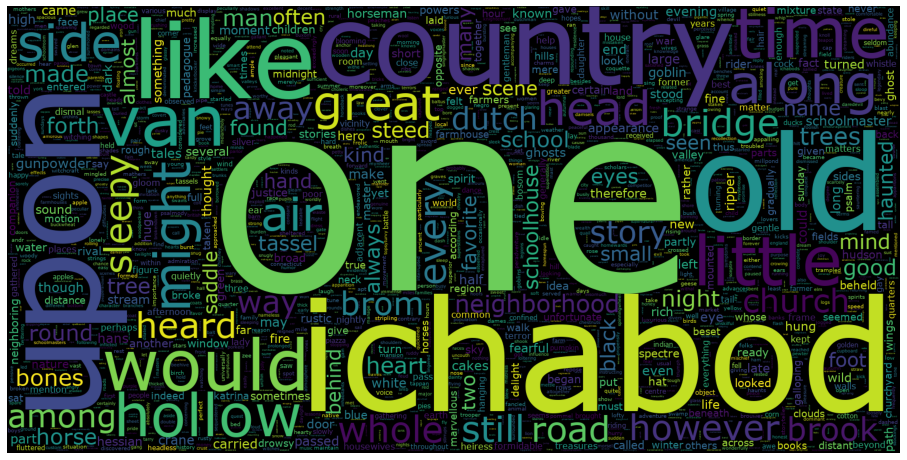

In [17]:
word_plotter("./data/SleepyHollow.txt")

***
### Treasure Island

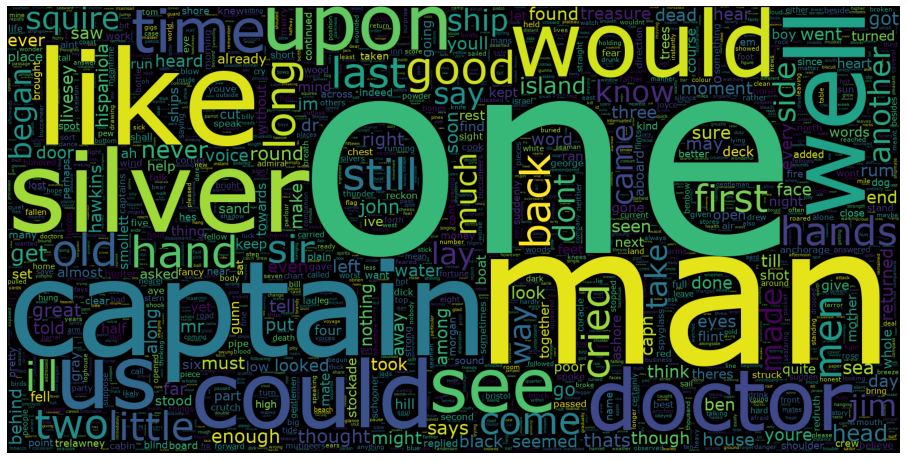

In [18]:
word_plotter("./data/TreasureIsland.txt")

***
### The Republic

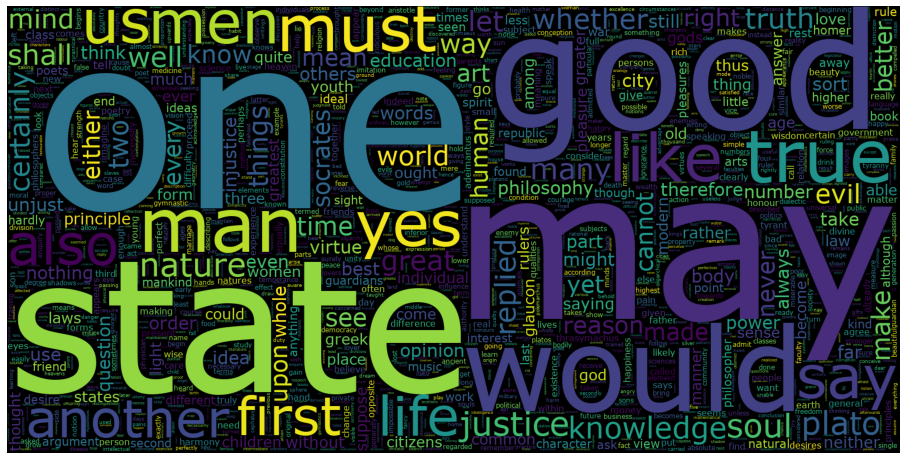

In [19]:
word_plotter("./data/Republic.txt")

***
***
# Workshop - Some questions to explore with Spark!
## 1 - How might we quantify the complexity of a book? (Example Scrabble scoring)
## 2 - How can we visualize complexity of several books at the same time? 

***
### Letter point values

In [20]:
LP = {'a':1,'b':4,'c':4,'d':2,'e':1,'f':4,'g':3,\
      'h':3,'i':1,'j':10,'k':5,'l':2,'m':4,'n':2,\
      'o':1,'p':4,'q':10,'r':1,'s':1,'t':1,'u':2,\
      'v':5,'w':4,'x':8,'y':3,'z':10}

***
### Function which takes a string (word) and returns total point value

In [21]:
# word (string)
# returns number of points in word (int)
def word_points(word):
    points = 0
    for letter in word:
        try:
            points += LP[letter.lower()]
        except:
            print("%s not in LP" % letter)
            points += 0
    return points

# should return 4
word_points("test")

4

***
### Function which takes a txt filename and returns average scrabble score (double)
#### Average scrabble score defined as [total score for all words in book] / [total number of words in book]

In [22]:
def average_scrabble_score(text_file):
    rd0 = sc.textFile(text_file).\
                      flatMap(lambda x: x.split(" ")).\
                      map(lambda x: word_transform(x)).\
                      filter(lambda word: word not in stop_words).\
                      map(lambda x: word_points(x))

    rd0.cache()
    N_words = rd0.count()
    N_points = rd0.reduce(lambda x,y: x+y)

    return float(N_points)/float(N_words)

# should return 11.65
print("Moby Dick  -> %2.2f" % (average_scrabble_score("./data/MobyDick.txt")))

Moby Dick  -> 11.67


***
### Run the function on a collection of books

In [23]:
Books = {"Moby Dick":                     {"fid": "./data/MobyDick.txt",       "year": 1851},
         "Treasure Island":               {"fid": "./data/TreasureIsland.txt", "year": 1883},
         "The Republic":                  {"fid": "./data/Republic.txt",       "year": -380},
         "Legend of Sleepy Hollow":       {"fid": "./data/SleepyHollow.txt",   "year": 1820},
         "Pride and Predjudice":          {"fid": "./data/PridePrejudice.txt", "year": 1813},
         "Goosebumps: Say Cheese or Die": {"fid": "./data/SayCheeseDie.txt",   "year": 1992},
         "War and Peace":                 {"fid": "./data/WarAndPeace.txt",    "year": 1869},
         "Julius Ceasar":                 {"fid": "./data/JuliusCaesar.txt",   "year": 1599},
         }

for book in Books.keys():
    try:
        Books[book]["score"] = average_scrabble_score(Books[book]["fid"])
        print("%-40s -> %2.2f" % (book+" ("+str(Books[book]["year"])+")", Books[book]["score"]) )
    except:
        print("%s failed!!" % book)

Moby Dick (1851)                         -> 11.67
Treasure Island (1883)                   -> 10.49
The Republic (-380)                      -> 11.81
Legend of Sleepy Hollow (1820)           -> 12.02
Pride and Predjudice (1813)              -> 12.22
Goosebumps: Say Cheese or Die failed!!
War and Peace (1869)                     -> 11.30
Julius Ceasar (1599)                     -> 10.37
